# 1. Introduction

# 2. Dataset Description

# 3. Exploratory Data Analysis (EDA)

# 4. Text Preprocessing

# 5. Feature Extraction (TF-IDF)

# 6. Model Training

# 7. Model Evaluation

# 8. Interpretation (Important Words)

# 9. Conclusion

In [3]:
import pandas as pd

df = pd.read_csv("Amazon_Reviews.csv")
df.head()

,Reviewer Name,Profile Link,Country,Review Count,Review Date,Rating,Review Title,Review Text,Date of Experience
0,Eugene ath,/users/66e8185ff1598352d6b3701a,US,1 review,2024-09-16T13:44:26.000Z,Rated 1 out of 5 stars,A Store That Doesn't Want to Sell Anything,"I registered on the website, tried to order a ...","September 16, 2024"
1,Daniel ohalloran,/users/5d75e460200c1f6a6373648c,GB,9 reviews,2024-09-16T18:26:46.000Z,Rated 1 out of 5 stars,Had multiple orders one turned up and…,Had multiple orders one turned up and driver h...,"September 16, 2024"
2,p fisher,/users/546cfcf1000064000197b88f,GB,90 reviews,2024-09-16T21:47:39.000Z,Rated 1 out of 5 stars,I informed these reprobates,I informed these reprobates that I WOULD NOT B...,"September 16, 2024"
3,Greg Dunn,/users/62c35cdbacc0ea0012ccaffa,AU,5 reviews,2024-09-17T07:15:49.000Z,Rated 1 out of 5 stars,Advertise one price then increase it on website,I have bought from Amazon before and no proble...,"September 17, 2024"
4,Sheila Hannah,/users/5ddbe429478d88251550610e,GB,8 reviews,2024-09-16T18:37:17.000Z,Rated 1 out of 5 stars,If I could give a lower rate I would,If I could give a lower rate I would! I cancel...,"September 16, 2024"


In [5]:
# Extract numeric rating (1–5) from text
df['Rating_num'] = df['Rating'].str.extract(r'(\d)').astype(float)

df[['Rating', 'Rating_num']].head()


,Rating,Rating_num
0,Rated 1 out of 5 stars,1.0
1,Rated 1 out of 5 stars,1.0
2,Rated 1 out of 5 stars,1.0
3,Rated 1 out of 5 stars,1.0
4,Rated 1 out of 5 stars,1.0


In [6]:
df = df.dropna(subset=['Review Text', 'Rating_num'])

In [7]:
df['sentiment'] = df['Rating_num'].apply(
    lambda x: 'positive' if x >= 4 else 'negative'
)

df['sentiment'].value_counts()

,count
sentiment,
negative,5421
positive,800


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

TEXT_COL = 'Review Text'
LABEL_COL = 'sentiment'

X = df[TEXT_COL].astype(str)
y = df[LABEL_COL].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=2000)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=2000)

              precision    recall  f1-score   support

    negative       0.92      0.99      0.95      1085
    positive       0.90      0.40      0.55       160

    accuracy                           0.92      1245
   macro avg       0.91      0.70      0.75      1245
weighted avg       0.92      0.92      0.90      1245



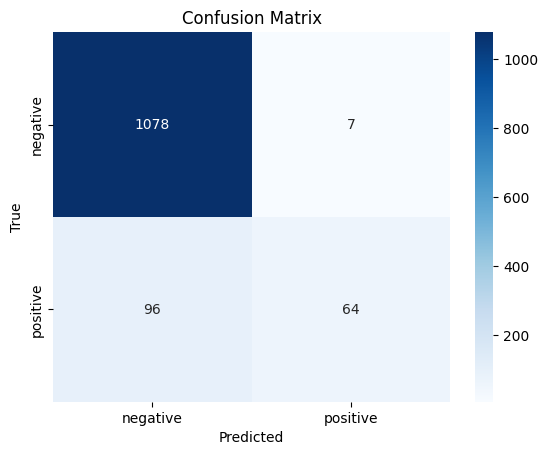

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [12]:
import numpy as np

feature_names = np.array(tfidf.get_feature_names_out())

coef = model.coef_[0]  # binary => one vector

# class mapping: positive weights push towards model.classes_[1]
class_neg = model.classes_[0]
class_pos = model.classes_[1]

top_pos_idx = np.argsort(coef)[-20:]      # biggest positive weights
top_neg_idx = np.argsort(coef)[:20]       # most negative weights

print(f"Class with positive weights: {class_pos}")
print(f"Class with negative weights: {class_neg}")

print(f"\nTop words for class '{class_pos}' (most positive weights):")
print(feature_names[top_pos_idx][::-1])

print(f"\nTop words for class '{class_neg}' (most negative weights):")
print(feature_names[top_neg_idx])

Class with positive weights: positive
Class with negative weights: negative

Top words for class 'positive' (most positive weights):
['great' 'easy' 'love' 'fast' 'thank' 'good' 'amazing' 'excellent' 'best'
 'quickly' 'problems' 'experience' 'helpful' 'thanks' 'perfect' 'reliable'
 'online' 'problem' 'issues' 'quick']

Top words for class 'negative' (most negative weights):
['account' 'money' 'told' 'worst' 'don' 'poor' 'refund' 'just' 'seller'
 'said' 'customers' 'email' 'terrible' 'saying' 'trying' 'days' 'paid'
 'received' 'longer' 'useless']


In [13]:
import pandas as pd

top_pos = pd.DataFrame({"word": feature_names[top_pos_idx][::-1],
                        "weight": coef[top_pos_idx][::-1]})

top_neg = pd.DataFrame({"word": feature_names[top_neg_idx],
                        "weight": coef[top_neg_idx]})

display(top_pos.head(15))
display(top_neg.head(15))

,word,weight
0,great,5.685570
1,easy,3.480763
2,love,3.404570
3,fast,3.250466
4,thank,3.082244
5,good,2.966111
6,amazing,2.908692
7,excellent,2.851354
8,best,2.813924
9,quickly,2.481133


,word,weight
0,account,-2.600589
1,money,-2.109729
2,told,-1.969445
3,worst,-1.772523
4,don,-1.620898
5,poor,-1.572890
6,refund,-1.561302
7,just,-1.444945
8,seller,-1.432205
9,said,-1.397194
